In [29]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt
import json

**Task 1: Author analysis**

In [2]:
elastic_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\elastic\\elasticsearch"

In [3]:
repo = pydriller.Repository(elastic_path, from_tag="v1.0.0", to_tag="v1.1.0")

In [4]:
# we create the dictionary author => number of modified files

authors_nmodif_dictionary = {}
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.new_path is not None:
            if mf.new_path.endswith('java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1
        # to consider moved files (the old path is different to the new, and it is not none)
        if mf.old_path is not None and mf.old_path != mf.new_path:
            if mf.old_path.endswith('java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1   
authors_nmodif_dictionary = {k: v for k, v in sorted(authors_nmodif_dictionary.items(), key=lambda item: item[1], reverse=True)}

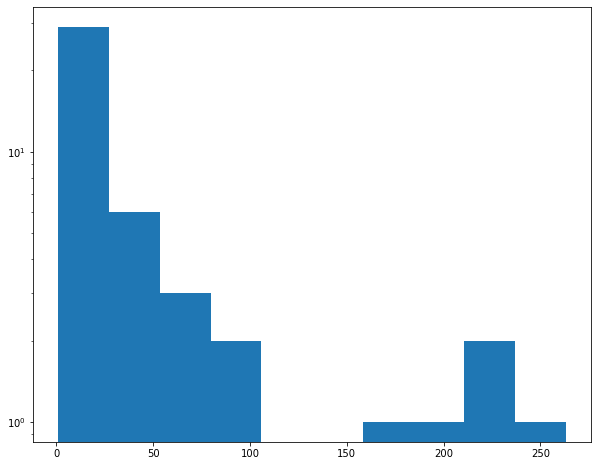

In [5]:
# visualization: number of authors (y) who modified n files (x)

plt.figure(figsize=(10,8))
plt.hist(list(authors_nmodif_dictionary.values()), bins=10)
plt.yscale('log')
plt.show()

In [6]:
# we create the dictionary file => number of authors

file_author_dictionary = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path is not None:
            if mf.new_path.endswith('java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
        # to consider moved files (the old path is different to the new, and it is not none)
        if mf.old_path is not None and mf.old_path != mf.new_path:
            if mf.old_path.endswith('java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
file_author_dictionary = {k: len(v) for k, v in file_author_dictionary.items()}
file_author_dictionary = {k: v for k, v in sorted(file_author_dictionary.items(), key=lambda item: item[1], reverse=True)}

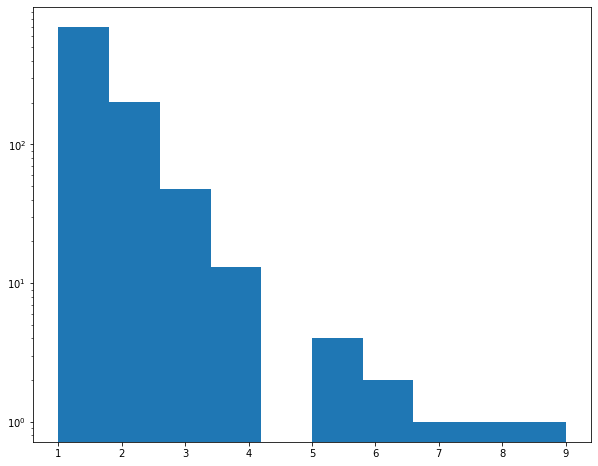

In [7]:
# visualization: number files (y) with n authors (x)

plt.figure(figsize=(10,8))
plt.hist(list(file_author_dictionary.values()), bins=10)
plt.yscale('log')
plt.show()

In [8]:
from enum import Enum

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [9]:
def count_lines(operation, file):
    if operation == Modification.ADDED:
        return file.added_lines
    elif operation == Modification.REMOVED:
        return file.deleted_lines
    elif operation == Modification.DIFF:
        return file.added_lines - file.deleted_lines
    elif operation == Modification.TOTAL:
        return file.added_lines + file.deleted_lines
    else:
        raise "Invalid operation"
        
def get_modification_loc(operation, filepath):
    res = {}
    for c in repo.traverse_commits():
        author = c.author.name
        for mf in c.modified_files:
            # if the file has been removed, we checked if it was removed from the corresponding path
            if mf.new_path is None:
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # if the file has been added, we checked if it was added the to corresponding path
            elif mf.old_path is None:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # otherwise, we checked if the file is/was in the corresponding path
            else:
                if mf.new_path.startswith(filepath) or mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)

                            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

In [26]:
# we get the contributions for the three indicated packages

filepath = "src\\main\\java\\org\\elasticsearch\\search"
author_contributions_search = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\index"
author_contributions_index = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\action"
author_contributions_action = get_modification_loc(Modification.TOTAL, filepath)

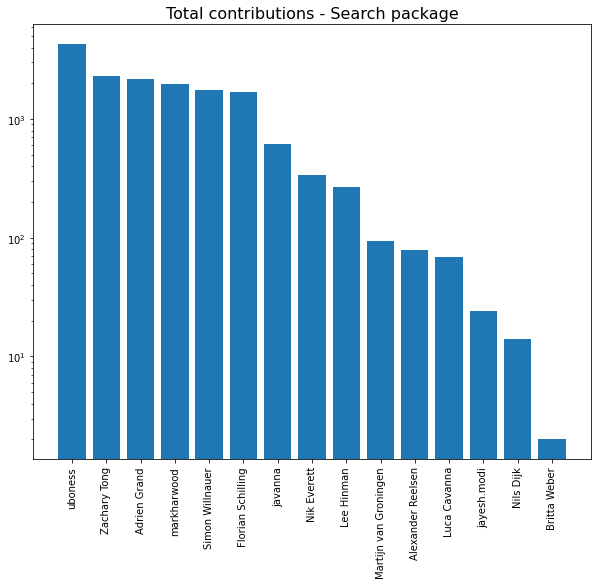

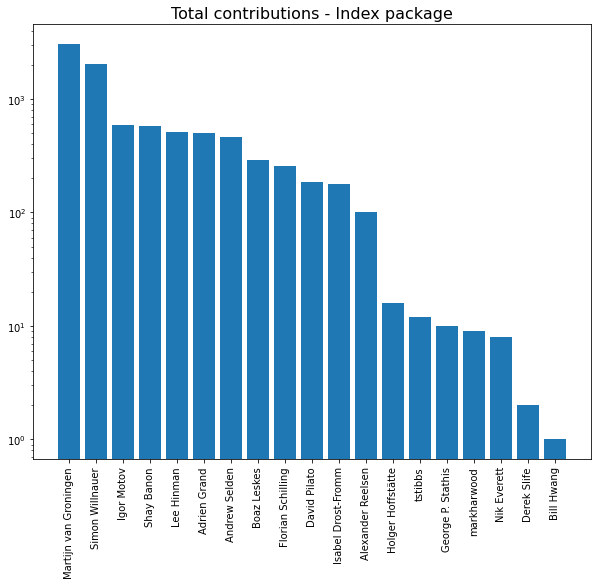

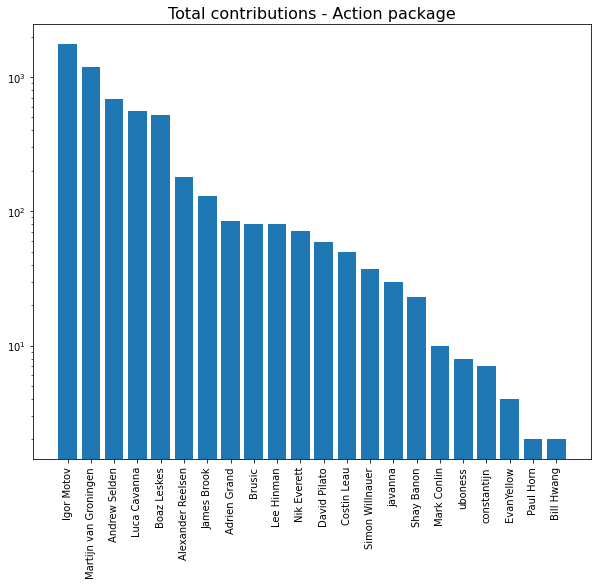

In [28]:
def plot_author_contributions(author_contributions, title):
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=16)
    plt.bar(author_contributions.keys(), author_contributions.values())
    plt.yscale('log')
    plt.xticks(rotation='vertical')
    plt.show()
    
plot_author_contributions(author_contributions_search, 'Total contributions - Search package')
plot_author_contributions(author_contributions_index, 'Total contributions - Index package')
plot_author_contributions(author_contributions_action, 'Total contributions - Action package')

**Task 2: Knowledge loss**

In [31]:
def generate_knowledge_loss_json(author_contributions, package_name):

    total_contribution = sum(list(author_contributions.values()))

    output_json = {}
    output_json["name"] = "root"

    children_node_d = {}
    children_node_d["name"] = package_name
    children_node_d["children"] = []

    for contributor, contribution in author_contributions.items():
        temp = {}
        temp["size"] = str(contribution)
        temp["name"] = contributor
        temp["weight"] = contribution
        temp["ownership"] = contribution/total_contribution
        temp["children"] = []
        children_list.append(temp)

    children_node_d["children"] = children_list

    children_node = []
    children_node.append(children_node_d)

    output_json["children"] = children_node

    with open(f"{package_name}.json", "w") as file:
        json.dump(output_json, file, indent=4)

In [32]:
# this generates the json needed for the knowledge loss map
generate_knowledge_loss_json(author_contributions_action, "action_package")